## 0. Import packages

In [2]:
# model imports

import numpy as np

import utils
from het_block import het
import simple_block as sim
from simple_block import simple
from rouwenhorst import rouwenhorst
import jacobian as jac
import nonlinear
import HANK_durables as hank
import determinacy as det
from scipy import optimize
import Monte_Carlo

# DAG imports
import networkx as nx
import matplotlib.pyplot as plt
import pylab
import pandas as pd

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

<a id="2-calibration"></a>

## 1. Calibrating the steady state


In [3]:
household = hank.household

In [4]:
def hank_ss(Bg_Y=0.26,beta_guess=0.9745, r=0.03/4, sigma_N=1.0, sigma_D=1.0, delta=0.1, alpha = 2.0, vareps=10.0, tau_e = 1,  rho_e=0.9777, sigma_e=0.1928,
            phi_pi=1.5, phi_y = 0.125, theta = 1.0001, xi = 105, Ne=7, Nb=80, Nd=90,  bmax=200, dmax=135):
    """Solve steady state of full GE model. Calibrate beta to hit target interest rate where parameters adjust to get N=1, Y=1, Q=1"""

    # a. set up grids
    psi = 0.5 # "bmin":: psi*Y, Y=1
    b_grid = utils.agrid(amax=bmax, n=Nb, amin=-psi)
    d_grid = utils.agrid(amax=dmax, n=Nd, amin=1e-6)
    e_grid_log, e_ergodic, Pi_e = rouwenhorst(rho_e,sigma_e,Ne)
    e_grid = np.exp(e_grid_log) / np.sum(e_ergodic * np.exp(e_grid_log)) # normalize so E[e]=1
    Nk = Nd # number of grid points for lagrange multiplier grid
    kmax = 1.0 # 1 = max for lagrange mult.
    k_grid = utils.agrid(amax=kmax,n=Nk,amin=0)
     
    # b. solve analytically what we can (zero inflation s.s.)
    N = 1.0 # as psi_N = W/P_n * 1/C, psi_N found after root finding
    Q = 1.0 # as chi = C / (C+D), chi found after root finding
    A = 1.0/N # s.s. TFP level, set such that Y = 1
    markup_p_ss = vareps/(vareps-1) # P mark-up
    P = 1.0 # numeriare
    W = (A*P)/markup_p_ss
    Y = A*N # Y = 1
    P_n = P # price of non-durables, follows from retailer price relation
    P_d = P # price of durables, follows from retailer price relation
    Div = Y - N*(W/P) # s.s. profits
    Bg = Bg_Y*Y
    Tax = r*Bg
    
    #B_y moms['B_demand'] / (4*moms['Y'])

    # c. initialize guess for policy function iteration
    c = (b_grid[:, np.newaxis] + d_grid)/2
    c[c<0] = 1e-8 # assert c>0
    d = c 
    Vb = c**(-1/sigma_N) * np.ones((e_grid.shape[0], 1, 1))
    Vd = d**(-1/sigma_N) * np.ones((e_grid.shape[0], 1, 1))
        
    # d. pre-compute RHS of combined F.O.C. optimality condition
    P_d_p = P_d/P
    rhs = P_d_p + alpha*((d_grid[:, np.newaxis]/d_grid[np.newaxis, :]) - (1-delta)) # P_d/P + partial Psi/partial d'

    # e. define residual function
    def residual(x0):

        # a. solve household ss problem
        out = household.ss(Vd=Vd, Vb=Vb, Pi_e=Pi_e, b_grid=b_grid, dg_grid=d_grid, k_grid=k_grid, e_grid=e_grid, e_ergodic=e_ergodic, sigma_N=sigma_N, sigma_D=sigma_D,
                                 alpha=alpha,delta=delta,r=r,Div=Div,beta=x0,Ne=Ne,Nb=Nb,Nd=Nd,Nk=Nk,P=P,P_d=P_d,P_n=P_n,W=W,N=N,tau_e=tau_e,Tax=Tax)
        
        print(x0,[out['B'] - Bg],out['DG'],out['C'])
                                 
        return np.array([out['B'] - Bg]) # bonds are in zero net-supply

    # f. solve for beta given asset market clearing
    # i. call optimizer
    result = optimize.root_scalar(residual,bracket=[1/(1+r)-0.05,1/(1+r)],method='bisect') # cannot go higher than 1/(1+r)
    # ii. save result
    beta = result.root
    

    # g. extra evaluation for reporting
    ss = household.ss(Vd=Vd, Vb=Vb, Pi_e=Pi_e, b_grid=b_grid, dg_grid=d_grid, k_grid=k_grid, e_grid=e_grid, e_ergodic=e_ergodic, sigma_N=sigma_N, sigma_D=sigma_D,
                                 alpha=alpha,delta=delta,r=r,Div=Div,beta=beta,Ne=Ne,Nb=Nb,Nd=Nd,Nk=Nk,P=P,P_d=P_d,P_n=P_n,W=W,N=N,tau_e=tau_e,Tax=Tax)
    
    # h. update parameters that take adjustment for hitting targets in wage schedule and combined retailer FOC equations
    psi_N = (W/P) * (1/ss['C'])
    chi = ss['C']/(ss['C']+ss['C_D'])
        
    # h. add aggregate variables
    ss.update({'phi_pi': phi_pi, 'phi_y': phi_y, 'Y': Y, 'Y_ss': Y, 'rstar': r, 'markup_p_ss': markup_p_ss, 'markup_p': markup_p_ss, 'A': A, 'Bg': Bg, 'N': N, 'P': P, 'Pi': P/P, 'W': W,
               'chi': chi, 'psi_N': psi_N, 'dg_grid': d_grid, 'Q': Q, 'P_d': P_d, 'P_n': P_n, 'Div': Div, 'vareps': vareps, 'phi_pi': phi_pi, 'phi_y': phi_y,
               'theta': theta, 'xi': xi, 'sigma_N': sigma_N, 'sigma_D': sigma_D, 'e_ergodic': e_ergodic,'ssflag': False}) # P_d=P_n=P+eps for numerical stability
    return ss

In [5]:
ss = hank_ss()
ss['beta']

0.9425558312655086 [-0.7588726558750307] 3.4738806960215327 0.6015055713481615
0.9925558312655086 [529.3831250534024] 21.73565218684206 2.5796858482734915
0.9675558312655086 [-0.1829137045505776] 3.939766311143383 0.5545464252700709
0.9800558312655085 [4.56566785806505] 4.3055891774937365 0.5523284024586822
0.9738058312655086 [1.0711234657801016] 4.089660829252733 0.5483046147188609
0.9706808312655086 [0.296577747875462] 4.010329736356702 0.5507169651498264
0.9691183312655086 [0.027829320719889306] 3.9742178399989063 0.5524871531557816
0.9683370812655085 [-0.08404037232440323] 3.9568117490847374 0.5534834819887483
0.9687277062655085 [-0.029900716780248082] 3.9654657860463787 0.5529757905798187
0.9689230187655086 [-0.0015820384446209035] 3.969829848466229 0.5527281108621732
0.9690206750155086 [0.01302293395081966] 3.9720207339150835 0.5526071763247365
0.9689718468905085 [0.005695323357883919] 3.970924449141478 0.5526675347445642
0.9689474328280085 [0.0020505099851748643] 3.9703769795419

0.9689336615953835

# 2. Steady-state distributions plots and tables

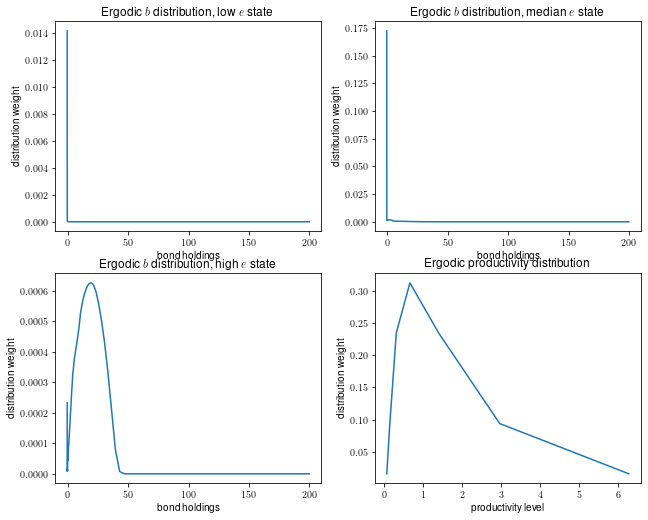

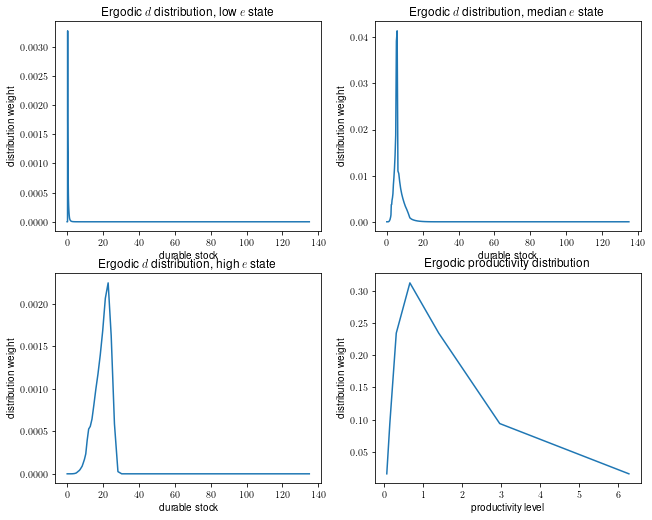

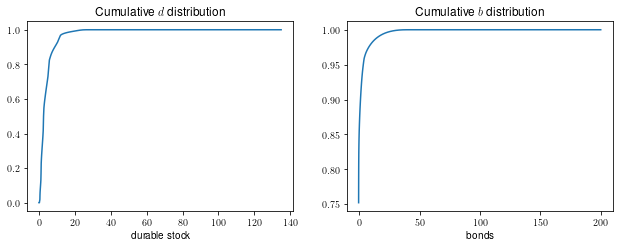

In [5]:
# a. marginal distributions
bdmargdist = np.sum(ss['D'],axis=0) # sum out e
dmargdist = np.sum(ss['D'],axis=1) # sum out b
dmargcum = np.cumsum(dmargdist)
bmargdist = np.sum(ss['D'],axis=2) # sum out d
bmargcum = np.cumsum(bmargdist)
e_ergodic = ss['e_ergodic']

# b. cumulative distributions
d_margdist = np.sum(bdmargdist,axis=0) # sum out b
dmargcum = np.cumsum(d_margdist)
b_margdist = np.sum(bdmargdist,axis=1) # sum out d
bmargcum = np.cumsum(b_margdist)

bmargcumfrac = np.cumsum(b_margdist*ss['b_grid']) 
bmargcumfrac /= bmargcumfrac[-1]

dmargcumfrac = np.cumsum(d_margdist*ss['dg_grid']) 
dmargcumfrac /= dmargcumfrac[-1]


# b. plots 
fig1 = plt.figure()
fig1.set_size_inches(10.5, 8.5)
ax1 = fig1.add_subplot(221)
ax1.plot(ss['b_grid'][:],bmargdist[0,:])
ax2 = fig1.add_subplot(222)
ax2.plot(ss['b_grid'][:],bmargdist[4,:])
ax3 = fig1.add_subplot(223)
ax3.plot(ss['b_grid'][:],bmargdist[-1,:])
ax4 = fig1.add_subplot(224)
ax4.plot(ss['e_grid'],ss['e_ergodic'])
ax1.title.set_text('Ergodic $b$ distribution, low $e$ state')
ax1.set_xlabel('bond holdings')
ax1.set_ylabel('distribution weight')
ax2.title.set_text('Ergodic $b$ distribution, median $e$ state')
ax2.set_xlabel('bond holdings')
ax2.set_ylabel('distribution weight')
ax3.title.set_text('Ergodic $b$ distribution, high $e$ state')
ax3.set_xlabel('bond holdings')
ax3.set_ylabel('distribution weight')
ax4.title.set_text('Ergodic productivity distribution')
ax4.set_xlabel('productivity level')
ax4.set_ylabel('distribution weight')
plt.show()
fig1.tight_layout(pad=7.0)
fig1.savefig("b_dists.pdf", bbox_inches='tight')

fig2 = plt.figure()
fig2.set_size_inches(10.5, 8.5)
ax1 = fig2.add_subplot(221)
ax1.plot(ss['dg_grid'][:100],dmargdist[0,:100])
ax2 = fig2.add_subplot(222)
ax2.plot(ss['dg_grid'][:100],dmargdist[4,:100])
ax3 = fig2.add_subplot(223)
ax3.plot(ss['dg_grid'][:100],dmargdist[-1,:100])
ax4 = fig2.add_subplot(224)
ax4.plot(ss['e_grid'],ss['e_ergodic'])
ax1.title.set_text('Ergodic $d$ distribution, low $e$ state')
ax1.set_xlabel('durable stock')
ax1.set_ylabel('distribution weight')
ax2.title.set_text('Ergodic $d$ distribution, median $e$ state')
ax2.set_xlabel('durable stock')
ax2.set_ylabel('distribution weight')
ax3.set_xlabel('durable stock')
ax3.set_ylabel('distribution weight')
ax3.title.set_text('Ergodic $d$ distribution, high $e$ state')
ax4.set_xlabel('durable stock')
ax4.set_ylabel('distribution weight')
ax4.title.set_text('Ergodic productivity distribution')
ax4.set_xlabel('productivity level')
ax4.set_ylabel('distribution weight')

plt.show()
fig2.tight_layout(pad=7.0)
fig2.savefig("d_dists.pdf", bbox_inches='tight')

fig3 = plt.figure()
fig3.set_size_inches(10.5, 3.5)
ax1 = fig3.add_subplot(121)
ax1.plot(ss['dg_grid'],dmargcum)
ax2 = fig3.add_subplot(122)
ax2.plot(ss['b_grid'],bmargcum)
ax1.title.set_text('Cumulative $d$ distribution')
ax1.set_xlabel('durable stock')
ax2.title.set_text('Cumulative $b$ distribution')
ax2.set_xlabel('bonds')

plt.show()
fig3.tight_layout(pad=4.0)
fig3.savefig("CDFs.pdf", bbox_inches='tight')

Skewness D/C: 0.402


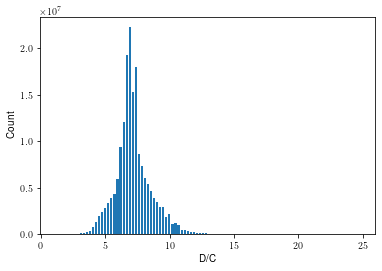

In [6]:
simT = 3000
simN = 90000
b_policy = ss['b']
d_policy = ss['dg']
c_policy = ss['c']
e_grid = ss['e_grid']
d_grid = ss['dg_grid']
b_grid = ss['b_grid']
e_ergodic = ss['e_ergodic']
Pi_e = ss['Pi_e']

sim_b,sim_d,sim_c = Monte_Carlo.steady_state_MC(simT,simN,b_policy,d_policy,c_policy,e_grid,b_grid,d_grid,e_ergodic,Pi_e)

sim_d_c = sim_d[1000:,:]/sim_c[1000:,:]
skewness_d_c = 3*(np.mean(sim_d_c) - np.median(sim_d_c))/np.std(sim_d_c) #0.4627878092589748 #0.4930580812805126 # 0.5322452262264995
print(f"Skewness D/C: {skewness_d_c:.3f}")

x = sim_d_c
hist, bins = np.histogram(x, bins=100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xlabel('D/C')
plt.ylabel('Count')
plt.show()

In [7]:
# a. percentiles
moms = {}
pvec = [0.001,0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99,0.999]
for p in pvec:

    # durable
    if p <= dmargcum[0]:
        moms[('d',p)] = ss['dg_grid'][0]
    else:
        try:
            moms[('d',p)] = np.interp(p,dmargcum,ss['dg_grid'])
        except:
            moms[('d',p)] = np.nan

    # bonds
    if p <= bmargcum[0]:
        moms[('b',p)] = ss['b_grid'][0]
    else:
        try:
            moms[('b',p)] = np.interp(p,bmargcum,ss['b_grid'])
        except:
            moms[('b',p)] = np.nan
            
# b. table
print('d percentiles')
for p in reversed(pvec):
    print("%.3f" % p,"%.2f" % moms['d',p])
print('')
print('b percentiles')
for p in reversed(pvec):
    print("%.3f" % p,"%.2f" % moms['b',p])

d percentiles
0.999 24.21
0.990 18.54
0.950 11.20
0.900 8.76
0.750 5.14
0.500 2.52
0.250 1.31
0.100 0.84
0.050 0.55
0.010 0.33
0.001 0.21

b percentiles
0.999 30.06
0.990 15.83
0.950 3.37
0.900 1.05
0.750 -0.50
0.500 -0.50
0.250 -0.50
0.100 -0.50
0.050 -0.50
0.010 -0.50
0.001 -0.50


# 3. Linearized dynamics

## 3.1 Pre-requisite price relations from retailer FOC's

From the combined retailer F.O.C. we obtain $C_{d,t}(C_{d,t},Q_t)$
$$\left(\frac{\chi C_{d,t}}{(1-\chi)C_{t}}\right)^{\frac{1}{\theta}}=\frac{1}{Q_{t}}$$
$$\Rightarrow C_{d,t}=C_{t}Q_{t}^{-\theta}\left(\frac{1-\chi}{\chi}\right)$$

Thus, we obtain $P_{n,t}$ from retailer FOC wrt. $C_t$
$$\begin{array}{c}
\Rightarrow P_{t}\left[(\chi)^{\frac{1}{\theta}}{C_{t}^{-\frac{1}{\theta}}}\left[(\chi)^{\frac{1}{\theta}}{\left(C_{t}\right)^{\frac{\theta-1}{\theta}}}+(1-\chi)^{\frac{1}{\theta}}\left({C_{t}}Q_{t}^{-\theta}\left(\frac{1-\chi}{\chi}\right)\right)^{\frac{\theta-1}{\theta}}\right]^{\frac{1}{\theta-1}}\right]=P_{n,t}\\
\Rightarrow P_{t}\left[(\chi)^{\frac{1}{\theta}}\left[(\chi)^{\frac{1}{\theta}}+(1-\chi)^{\frac{1}{\theta}}\left(Q_{t}^{-\theta}\left(\frac{1-\chi}{\chi}\right)\right)^{\frac{\theta-1}{\theta}}\right]^{\frac{1}{\theta-1}}\right]=P_{n,t}\\
\Rightarrow P_{t}\left[(\chi)^{\frac{1}{\theta}\frac{\theta-1}{1}}\left[(\chi)^{\frac{1}{\theta}}+(1-\chi)^{\frac{1}{\theta}}\left(Q_{t}^{-\theta}\left(\frac{1-\chi}{\chi}\right)\right)^{\frac{\theta-1}{\theta}}\right]^{\frac{1}{\theta-1}}\right]=P_{n,t}\\
\Rightarrow P_{t}\left[\left[(\chi)^{\frac{1}{\theta}\frac{\theta-1}{1}}(\chi)^{\frac{1}{\theta}}+(\chi)^{\frac{1}{\theta}\frac{\theta-1}{1}}(1-\chi)^{\frac{1}{\theta}}\left(Q_{t}^{-\theta}\left(\frac{1-\chi}{\chi}\right)\right)^{\frac{\theta-1}{\theta}}\right]^{\frac{1}{\theta-1}}\right]=P_{n,t}\\
\Rightarrow P_{t}\left[\left[(\chi)^{\frac{1}{\theta}+\frac{1}{\theta}\frac{\theta-1}{1}}+(\chi)^{\frac{1}{\theta}\frac{\theta-1}{1}}(1-\chi)^{\frac{1}{\theta}}Q_{t}^{1-\theta}\left(1-\chi\right)^{\frac{\theta-1}{\theta}}\chi^{\frac{1-\theta}{\theta}}\right]^{\frac{1}{\theta-1}}\right]=P_{n,t}\\
\Rightarrow P_{t}\left[\left[(\chi)^{\frac{1}{\theta}+\frac{1}{\theta}\frac{\theta-1}{1}}+(\chi)^{\frac{1}{\theta}\frac{\theta-1}{1}+\frac{1-\theta}{\theta}}(1-\chi)^{\frac{1}{\theta}+\frac{\theta-1}{\theta}}Q_{t}^{1-\theta}\right]^{\frac{1}{\theta-1}}\right]=P_{n,t}\\
\Rightarrow P_{t}\left[\left[(\chi)^{1}+{(\chi)^{0}}(1-\chi)^{1}Q_{t}^{1-\theta}\right]^{\frac{1}{\theta-1}}\right]=P_{n,t}\\
\Rightarrow\frac{P_{t}}{P_{n,t}}=\left[\chi+(1-\chi)Q_{t}^{1-\theta}\right]^{\frac{1}{1-\theta}}
\end{array}$$

so $P_{n,t}=\left[\chi+(1-\chi)Q_{t}^{1-\theta}\right]^{\frac{1}{\theta-1}}P_{t}$

which pins downs $P_{d,t}$
$$P_{d,t}=P_{n,t}\cdot Q_t$$


## 3.1 Equilibrium equations neccessary to compute impulse responses

\begin{equation} P_{n,t}=\left[\chi+(1-\chi)Q_{t}^{1-\theta}\right]^{\frac{1}{\theta-1}}P_{t} \end{equation}

\begin{equation} P_{d,t}=P_{n,t}Q_t \end{equation}

\begin{equation} \Pi_{t}=\frac{P_{t}}{P_{t-1}} \end{equation}

\begin{equation} \mathcal{M}_{t}^{p}=\frac{1}{\frac{\xi}{\epsilon}\left(\Pi_{t}\left(\Pi_{t}-1\right)-\frac{1}{1+r_{t+1}}\left(\frac{Y_{t+1}}{Y_{t}}\right)\Pi_{t+1}\left(\Pi_{t+1}-1\right)\right)+\frac{1}{\mathcal{M}^{p}}} \end{equation}

\begin{equation} i_{t}=r_{t}^{*}+\phi_{\pi}\pi_{t}+\phi_{y} \hat{y}_t \end{equation}

\begin{equation} r_{t}=\frac{1+i_{t}}{1+\pi_{t}}-1 \end{equation}

\begin{equation} N_{t}=Y_{t}/A_{t} \end{equation}

\begin{equation} W_{t}=\frac{A_{t} P_{t}}{\mathcal{M}_{t}^{p} } \end{equation}

\begin{equation} Div_{t}=Y_{t}\left(1-(\xi/2)\left(\Pi_{t}-1\right)^{2}\right)-\frac{W_{t}}{P_{t}}N_{t} \end{equation}

\begin{equation} B_{t}=0 \end{equation}

\begin{equation} P_{n,t}C_{t}+P_{n,t}Q_tC_{d,t}-P_{t}Y_{t}=0 \end{equation}

\begin{equation} \frac{W_{t}}{P_{t}}=\psi_N N_{t}C_{n,t} \end{equation}

The endogenous variables are $U=(Y_{t},P_{t},Q_{t})$, the exogenous
variables are $Z=(r_{t}^{*},A_{t})$. With the following targets,
the system to be solved is given as

\begin{equation}
H\left(Y_{t},P_{t},Q_{t}\right)=\left(\begin{array}{c}
\text{Bonds market clearing}\\
\text{Retailer zero-profit condition}\\
\text{Wage schedule}
\end{array}\right)=\left(\begin{array}{c}
0\\
0\\
0
\end{array}\right)
\end{equation}

Denoting household solution variables as caligraphic variables for
$\mathcal{B},\mathcal{D},\mathcal{C}$, the system is explicitly

\begin{equation}
H\left(Y_{t},P_{t},Q_{t}\right)=\left(\begin{array}{c}
\mathcal{B}_{t}\\
P_{n,t}\mathcal{C}_{n,t} + P_{n,t}Q_t\mathcal{C}_{d,t} - P_t Y_t\\
\frac{W_{t}}{P_{t}}-\psi_{N}N_{t}\mathcal{C}_{n,t}
\end{array}\right)=\left(\begin{array}{c}
0\\
0\\
0
\end{array}\right)
\end{equation}


## 3.2 Define simple blocks (eq. by eq.)

In [9]:
@simple
def prices(P,Q,chi,theta): # non-durable price from retailer FOC, durable price through Q definition
    P_n = P*(chi + (1-chi)*Q**(1-theta))**(1/(theta-1))
    P_d = Q*P_n
    return P_n,P_d

@simple
def inflation(P): # inflation definition
    Pi = P/P(-1) 
    return Pi

@simple
def markup_p(Pi,Y,xi,vareps,markup_p_ss,r): # P mark-up through Phillips curve
    markup_p = 1/((xi/vareps)*( Pi*(Pi-1) - (1/(1+r(+1))) * (Y(+1)/Y)*Pi(+1)*(Pi(+1) - 1) ) - 1/markup_p_ss)
    return markup_p

@simple
def taylor(rstar,Pi,Y,Y_ss,phi_pi,phi_y): # monetary policy
    i_minus = rstar + phi_pi*np.log(Pi) + phi_y*np.log(Y/Y_ss) # Taylor rule
    r = (1+i_minus)/(1+np.log(Pi)) - 1 # Fisher equation
    return r

@simple
def labor_supply(Y,A): # labor supply as a function of output and TFP
    N = Y/A
    return N

@simple
def wage(A,P,markup_p): # wage relation
    W = A*P/markup_p
    return W

@simple
def dividends(Y,W,N,P,Pi,xi): # firm profits
    Div = Y*(1-(xi/2)*(Pi-1)**2) - (W*N)/P
    return Div

@simple
def bond_market_clearing(B,Bg): # bond market clearing
    bond_mkt = B - Bg
    return bond_mkt

@simple
def zero_profit_retailer(Q,C_D,C,P,P_n,Y,delta): # retailer zero-profit cond.
    retailer_res = P_n*C + P_n*Q*C_D - P*Y
    return retailer_res

@simple
def DG_t(DG):
    DG_t = DG(-1)
    return DG_t

@simple
def wage_schedule(W,P,N,C,psi_N): # wage schedule target
    wage_res = W/P - psi_N*N*C
    return wage_res

@simple
def fiscal(r, Bg,W,P,N):
    Tax = r*Bg
    return Tax


### 3.2 Cut to the chase
The surest way to obtain the general equilibrium Jacobians is to use the `get_G` convenience function. Notice the `save=True` option. This means that we're saving the HA Jacobians calculated along the way for later use.

In [10]:
# setup
T = 300
exogenous = ['rstar', 'A']
unknowns = ['Y','P','Q']
targets = ['bond_mkt','retailer_res','wage_res']

# general equilibrium jacobians
block_list = [prices,inflation,markup_p,taylor,labor_supply,wage,dividends,bond_market_clearing,zero_profit_retailer,wage_schedule,DG_t,fiscal,household] 
G = jac.get_G(block_list, exogenous, unknowns, targets, T, ss, save=True)

### 3.4 Results
First let's check that we have correctly reconstructed the steps of `jac.get_G`.

Now let's consider 20 basis point monetary policy shocks with different persistences and plot the response of inflation.

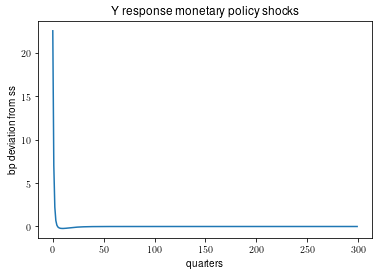

In [11]:
rhos = np.array([0.3]) # persistence

drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = (G['Y']['rstar'] @ drstar)
plt.plot(10000 * dpi[:])
plt.title(r'Y response monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

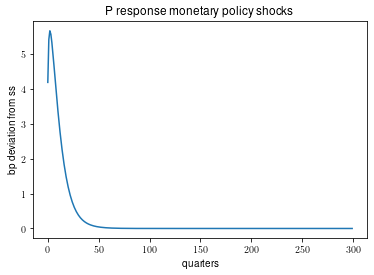

In [12]:
rhos = np.array([0.3]) # persistence

drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = (G['P']['rstar'] @ drstar)
plt.plot(10000 * dpi[:])
plt.title(r'P response monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

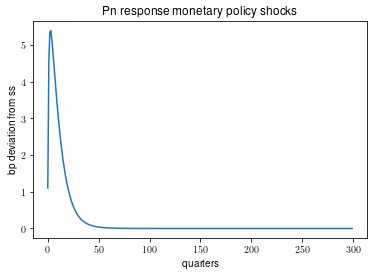

In [13]:
rhos = np.array([0.3]) # persistence

drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = (G['P_n']['rstar'] @ drstar)
plt.plot(10000 * dpi[:])
plt.title(r'Pn response monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

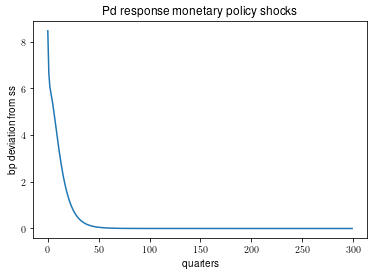

In [14]:
rhos = np.array([0.3]) # persistence

drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = (G['P_d']['rstar'] @ drstar)
plt.plot(10000 * dpi[:])
plt.title(r'Pd response monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

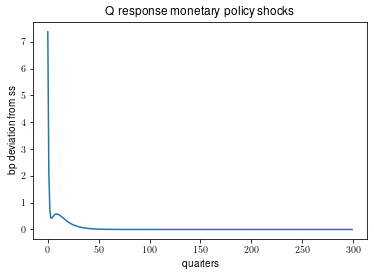

In [15]:
rhos = np.array([0.3]) # persistence

drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = (G['Q']['rstar'] @ drstar)
plt.plot(10000 * dpi[:])
plt.title(r'Q response monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

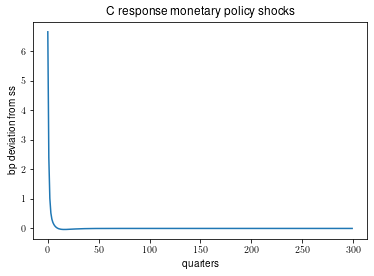

In [16]:
rhos = np.array([0.3]) # persistence

drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = (G['C']['rstar'] @ drstar)
plt.plot(10000 * dpi[:])
plt.title(r'C response monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

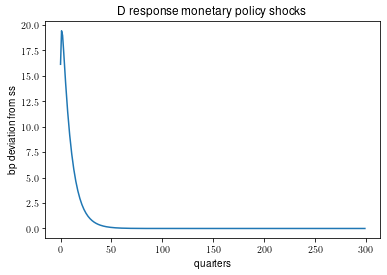

In [17]:
rhos = np.array([0.3]) # persistence

drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = (G['DG']['rstar'] @ drstar)
plt.plot(10000 * dpi[:])
plt.title(r'D response monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

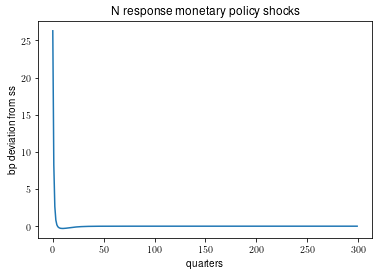

In [17]:
rhos = np.array([0.3]) # persistence

drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = (G['N']['rstar'] @ drstar)
plt.plot(10000 * dpi[:])
plt.title(r'N response monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

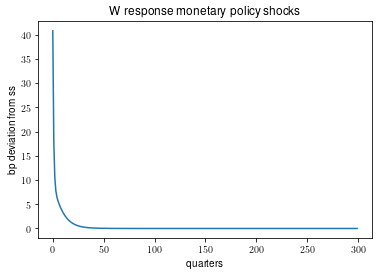

In [18]:
rhos = np.array([0.3]) # persistence

drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = (G['W']['rstar'] @ drstar)
plt.plot(10000 * dpi[:])
plt.title(r'W response monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

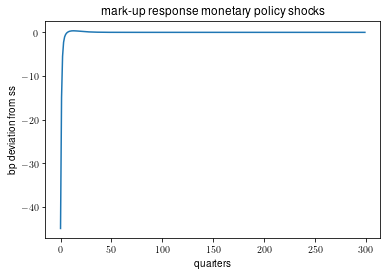

In [19]:
rhos = np.array([0.3]) # persistence

drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = (G['markup_p']['rstar'] @ drstar)
plt.plot(10000 * dpi[:])
plt.title(r'mark-up response monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

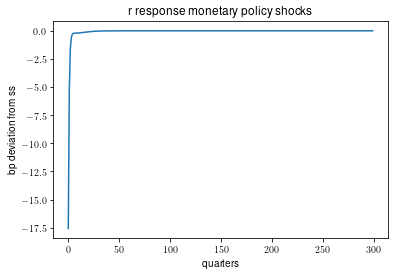

In [20]:
rhos = np.array([0.3]) # persistence

drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = (G['r']['rstar'] @ drstar)
plt.plot(10000 * dpi[:])
plt.title(r'r response monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

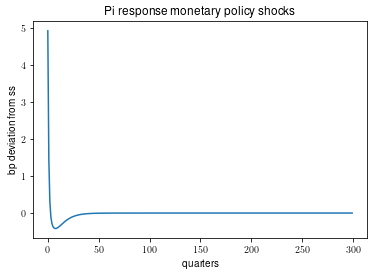

In [21]:
rhos = np.array([0.3]) # persistence

drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = (G['Pi']['rstar'] @ drstar)
plt.plot(10000 * dpi[:])
plt.title(r'Pi response monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

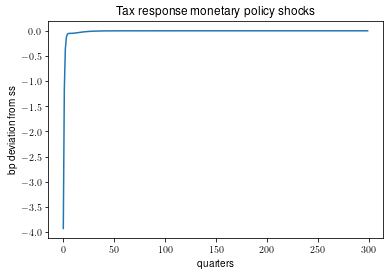

In [18]:
rhos = np.array([0.3]) # persistence

drstar = -0.002 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = (G['Tax']['rstar'] @ drstar)
plt.plot(10000 * dpi[:])
plt.title(r'Tax response monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()